# Настройки/Импорты

In [1]:
!pip install transformers==4.45.2
!pip install evaluate
!pip install seaborn==0.13.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 67.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [2]:
import os # для взаимодействия с системой
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом
import random as random # для работы со случайностью
import pickle # для сохранения и загрузки объектов
from tqdm.auto import tqdm # для отслеживания прогресса

from datasets import Dataset, load_dataset, load_from_disk # для работы с HuggingFace датасетами

import torch # для работы с моделями torch
from transformers import MarianMTModel, MarianTokenizer # для работы с Marian моделью
from transformers import DataCollatorForSeq2Seq # для сборщика данных (чтобы)
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer # для обучения модели
from transformers import EarlyStoppingCallback # callback для ранней остановки обучения

import time # для отслеживания времени выполнения
import matplotlib.pyplot as plt # для построения графиков
import seaborn as sns # для построения красивых графиков
import evaluate # для подсчёта метрик
from transformers.modelcard import parse_log_history # для парсинга логов обучения через Trainer

In [3]:
DATA_DIR = "/kaggle/working/data/" # путь до папки с данными
RESULTS_DIR = "/kaggle/working/results/" # путь до папки с результатами вычислений
EMBEDDING_DIR = "/kaggle/working/embeddings/" # путь до папки с эмбеддингами
MODELS_DIR = "/kaggle/working/models/" # путь до папки с моделями
MODEL_NAME = "Helsinki-NLP/opus-mt-ine-ine" # название модели для перевода
DATASET_NAME_HF = "aiana94/polynews-parallel"
DATASET_NAME_LOC = "polynews-parallel"

MAX_SEQUENCE_LEN = 256 # оптимальное число токенов в документе (если не достаёт — padding, если перебор — truncation), определялось по гистограмме распределения числа токенов в текстах

RANDOM_STATE = 42 # число для задания случайности
TEST_SIZE = 0.2 # размер тестовой выборки
TEST_MAX_SAMPLES = 10000 # максимальное число тестовых примеров
TRAIN_MAX_SAMPLES = 50000 # максимальное число обучающих примеров

EPOCHS = 10 # число эпох обучения
EPOCHS_PATIENCE = 2 # число эпох без изменения наблюдаемой метрики, после которого обучение прекратится
LEARNING_RATE = 0.00001 # learning rate
BATCH_SIZE = 25 # размер батча (число сэмплов, передаваемых в модель одновременно => чем больше значение - тем быстрее обучение, но хуже качество из-за аккумуляции градиентов)

In [4]:
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"Девайс: {DEVICE}.")

Девайс: cuda:0.


# Подготовка данных и модели

In [5]:
model = MarianMTModel.from_pretrained(MODEL_NAME)
model.save_pretrained(MODELS_DIR + MODEL_NAME, from_pt=True) # сохранение модели
model

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/266M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[42740]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(42741, 512, padding_idx=42740)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(42741, 512, padding_idx=42740)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [6]:
tokenizer = MarianTokenizer.from_pretrained(MODEL_NAME)
tokenizer.save_pretrained(MODELS_DIR + MODEL_NAME) # сохранение токенизатора
tokenizer

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/773k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


MarianTokenizer(name_or_path='Helsinki-NLP/opus-mt-ine-ine', vocab_size=42741, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	42740: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [7]:
dataset = load_dataset(DATASET_NAME_HF, name="eng_Latn-rus_Cyrl") # скачивание датасета, name — название subset_а с HuggingFace
dataset.save_to_disk(DATA_DIR + DATASET_NAME_LOC) # локальное сохранение датасета (в формате arrow)
dataset

README.md:   0%|          | 0.00/107k [00:00<?, ?B/s]

train.parquet.gzip:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/176441 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/176441 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['src', 'tgt', 'provenance'],
        num_rows: 176441
    })
})

In [8]:
dataset["train"][0]

{'src': 'Parliament Does Not Support Amendment Freeing Tymoshenko',
 'tgt': 'Парламент не поддерживает поправку, дающую свободу Тимошенко',
 'provenance': 'wmtnews'}

In [9]:
def preprocess_function(data: Dataset, random_state=RANDOM_STATE):
    random.seed(random_state) # Set the random number generator to a fixed sequence.
    samples_count = len(data["src"]) # общее число сэмплов в датасете
    
    reflected_idx = set(random.sample(range(0, samples_count), int(samples_count/2))) # индексы отражаемых сэмплов (set — для сортировки и удобного вычитания)
    regular_idx = set(range(0, samples_count)) - reflected_idx

    data["new_src"] = [">>rus<< " + sample if idx in regular_idx else ">>eng<< " + data["tgt"][idx] for idx, sample in enumerate(data["src"])]
    data["new_tgt"] = [sample if idx in regular_idx else data["src"][idx] for idx, sample in enumerate(data["tgt"])]
    model_inputs = tokenizer(data["new_src"], text_target=data["new_tgt"], max_length=MAX_SEQUENCE_LEN, return_tensors="pt", truncation=True, padding=True)
    return model_inputs

In [10]:
dataset = dataset.map(preprocess_function, batched=True)
dataset = dataset.remove_columns(["provenance", "src", "tgt"]) # удаление ненужной колонки
dataset = dataset.rename_column("new_src", "src") # переименовываем колонку
dataset = dataset.rename_column("new_tgt", "tgt") # переименовываем колонку
dataset = dataset["train"].train_test_split(test_size=TEST_SIZE, shuffle=True, seed=RANDOM_STATE) # разбиение датасета на тестовую и обучающую выборки ()
dataset

Map:   0%|          | 0/176441 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 141152
    })
    test: Dataset({
        features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 35289
    })
})

In [11]:
dataset["train"][0]

{'src': ">>eng<< Один из авторов блога Jumbie's Watch также был потрясен тем, как министр Сент-Роуз Гривз была избавлена от ответственности, хотя помнится она публично признала её. ",
 'tgt': "Diaspora blogger Jumbie's Watch was also confused as to how Minister St. Rose-Greaves was spared, since he remembers her publicly accepting responsibility. ",
 'input_ids': [42,
  22887,
  414,
  25175,
  824,
  1785,
  608,
  748,
  1995,
  13783,
  7,
  18,
  5,
  2505,
  158,
  7880,
  4249,
  117,
  1,
  1193,
  4543,
  3,
  1133,
  581,
  288,
  11761,
  425,
  7292,
  20,
  3956,
  220,
  8148,
  2835,
  718,
  361,
  462,
  5956,
  414,
  5948,
  16995,
  293,
  12751,
  4574,
  3573,
  3,
  21632,
  13505,
  377,
  9063,
  3484,
  4466,
  946,
  10542,
  11192,
  354,
  18690,
  2,
  0,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740,
  42740

In [12]:
dataset.save_to_disk(DATA_DIR + DATASET_NAME_LOC + "_marian_processed") # локальное сохранение датасета (в формате arrow)
# dataset = load_from_disk(DATA_DIR + DATASET_NAME_LOC + "_marian_processed") # загрузка локально сохранённого датасета

Saving the dataset (0/1 shards):   0%|          | 0/141152 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35289 [00:00<?, ? examples/s]

# [Fine-tuning](https://huggingface.co/docs/transformers/tasks/translation) (с использованием PyTorch)

In [13]:
# model = MarianMTModel.from_pretrained(MODELS_DIR + MODEL_NAME) # загружаем предобученную модель
# tokenizer = MarianTokenizer.from_pretrained(MODELS_DIR + MODEL_NAME) # загружаем предобученный токенизатор
dataset_tokenized = load_from_disk(DATA_DIR + DATASET_NAME_LOC + "_marian_processed") # загрузка локально сохранённого датасета
metric_BLEU = evaluate.load("bleu") # загружаем метрику

In [14]:
print(f"Число обучаемых параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad)}.") # считаем число параметров

Число обучаемых параметров: 66021888.


Обрежим датасет, чтобы время обучения не составляло несколько дней.

In [15]:
dataset_tokenized["train"] = dataset_tokenized["train"].select(range(TRAIN_MAX_SAMPLES))
dataset_tokenized["test"] = dataset_tokenized["test"].select(range(TEST_MAX_SAMPLES))
dataset_tokenized

DatasetDict({
    train: Dataset({
        features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
})

Получим токены для обучения, как входа модели, так и таргетов.

In [16]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors="pt") # сборщик данных для обучения, return_tensors — тип возвращаемого тензора (pt — Torch, tf — Tensorflow, np — Numpy)

In [17]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

In [18]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    preds_decoded = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    labels_decoded = tokenizer.batch_decode(labels, skip_special_tokens=True)

    preds_decoded, labels_decoded = postprocess_text(preds_decoded, labels_decoded)

    result = metric_BLEU.compute(predictions=preds_decoded, references=labels_decoded)
    result = {"bleu": result["bleu"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["mean_len"] = np.mean(prediction_lens)
    result = {k: round(v, 5) for k, v in result.items()} # округляем float до 5 знаков после запятой
    return result

In [19]:
if not os.path.exists(RESULTS_DIR + MODEL_NAME):
    os.makedirs(RESULTS_DIR + MODEL_NAME)

## Обучение модели

In [20]:
model.generation_config.max_new_tokens = MAX_SEQUENCE_LEN

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir=RESULTS_DIR + MODEL_NAME,
    # evaluation_strategy ="epoch",
    # evaluation_strategy="steps", # стратегия оценивания модели, "steps" - через несколько вызовов forward pass (нужен для работы EarlyStoping), "epoch" — по эпохам
    eval_strategy="steps",
    eval_steps=int(dataset_tokenized["train"].shape[0] / BATCH_SIZE), # подсчёт метрик и сохранение происходят каждые eval_steps шагов (нужно для работы для работы EarlyStoping), имитирующие одну эпоху
    save_strategy="steps", # стратегия сохранения модели, "steps" - через несколько вызовов forward pass (нужен для работы EarlyStoping), "epoch" — по эпохам
    save_steps=int(dataset_tokenized["train"].shape[0] / BATCH_SIZE), # для работы должен быть кратен eval_steps, если стратегии стоят как "steps"
    logging_strategy="steps", # стратегия подсчёта метрик на обучающей части
    logging_steps=int(dataset_tokenized["train"].shape[0] / BATCH_SIZE),
    learning_rate=LEARNING_RATE, # шаг обучения
    per_device_train_batch_size=BATCH_SIZE, # размер батча при обучении
    per_device_eval_batch_size=BATCH_SIZE, # размер батча при валидации
    weight_decay=0.01,
    save_total_limit=3, # количество сохраняемых чекпоинтов
    num_train_epochs=EPOCHS,
    predict_with_generate=True,
    
    fp16=True, # проводить ли обучение в float16 вместо float32
    bf16=False, # проводить обучение в float16 от google (так обучены некоторые модели google и они не умеют работать с обычным fp16 из-за возникающих ошибок переполнения)
    
    load_best_model_at_end=True, # загружать ли в конце обучения чекпоинт с лучшей метрикой (также 100% сохраняет лучший чекпоинт)
    metric_for_best_model="eval_bleu", # название метрики, по которой будет определяться лучший чекпоинт обучения
    greater_is_better=True, # должна ли отслеживаемая метрика увеличиваться
    use_cpu=False, # использовать ли для подсчёта устройства, отличные от CPU
    push_to_hub=False,
    report_to="none" # не запускать wandb backend
)

In [22]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["test"],
    tokenizer=tokenizer, # tokenizer -> processing_class
    # processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=EPOCHS_PATIENCE)] # callback_и для обучения, EarlyStoppingCallback — ранняя остановка
)

trainer.train()

Step,Training Loss,Validation Loss,Bleu,Mean Len
2000,0.477800,0.439823,0.166880,38.771400
4000,0.454800,0.427587,0.173600,38.629400
6000,0.438700,0.420518,0.178660,38.976300
8000,0.421600,0.415964,0.181120,38.696000
10000,0.416400,0.412576,0.182500,38.776500
12000,0.407800,0.410532,0.184350,38.858000
14000,0.401700,0.408684,0.185100,38.995200
16000,0.395400,0.407841,0.186070,38.906700
18000,0.397100,0.406817,0.185990,38.801400
20000,0.393600,0.406712,0.186460,38.780800


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].


TrainOutput(global_step=20000, training_loss=0.42344732360839843, metrics={'train_runtime': 24471.3801, 'train_samples_per_second': 20.432, 'train_steps_per_second': 0.817, 'total_flos': 3.36386451898368e+16, 'train_loss': 0.42344732360839843, 'epoch': 10.0})

In [23]:
trainer.model.save_pretrained(MODELS_DIR + MODEL_NAME + "_finetuned", from_pt=True) # сохранение модели
trainer.tokenizer.save_pretrained(MODELS_DIR + MODEL_NAME + "_finetuned", from_pt=True) # сохранение токенизатора
# trainer.processing_class.save_pretrained(MODELS_DIR + MODEL_NAME + "_finetuned", from_pt=True) # сохранение токенизатора

('/kaggle/working/models/Helsinki-NLP/opus-mt-ine-ine_finetuned/tokenizer_config.json',
 '/kaggle/working/models/Helsinki-NLP/opus-mt-ine-ine_finetuned/special_tokens_map.json',
 '/kaggle/working/models/Helsinki-NLP/opus-mt-ine-ine_finetuned/vocab.json',
 '/kaggle/working/models/Helsinki-NLP/opus-mt-ine-ine_finetuned/source.spm',
 '/kaggle/working/models/Helsinki-NLP/opus-mt-ine-ine_finetuned/target.spm',
 '/kaggle/working/models/Helsinki-NLP/opus-mt-ine-ine_finetuned/added_tokens.json')

In [24]:
trainer.state.log_history[:5]

[{'loss': 0.5713,
  'grad_norm': 1.0713402032852173,
  'learning_rate': 9.7525e-06,
  'epoch': 0.25,
  'step': 500},
 {'loss': 0.4944,
  'grad_norm': 1.1100685596466064,
  'learning_rate': 9.502500000000001e-06,
  'epoch': 0.5,
  'step': 1000},
 {'loss': 0.4849,
  'grad_norm': 1.1521131992340088,
  'learning_rate': 9.252500000000002e-06,
  'epoch': 0.75,
  'step': 1500},
 {'loss': 0.4778,
  'grad_norm': 1.1083863973617554,
  'learning_rate': 9.0025e-06,
  'epoch': 1.0,
  'step': 2000},
 {'eval_loss': 0.4398233890533447,
  'eval_bleu': 0.16688,
  'eval_mean_len': 38.7714,
  'eval_runtime': 1385.8468,
  'eval_samples_per_second': 7.216,
  'eval_steps_per_second': 0.289,
  'epoch': 1.0,
  'step': 2000}]

In [25]:
history = parse_log_history(trainer.state.log_history)
history

({'train_runtime': 24471.3801,
  'train_samples_per_second': 20.432,
  'train_steps_per_second': 0.817,
  'total_flos': 3.36386451898368e+16,
  'train_loss': 0.42344732360839843,
  'epoch': 10.0,
  'step': 20000},
 [{'Training Loss': 0.4778,
   'Epoch': 1.0,
   'Step': 2000,
   'Validation Loss': 0.4398233890533447,
   'Bleu': 0.16688,
   'Mean Len': 38.7714},
  {'Training Loss': 0.4548,
   'Epoch': 2.0,
   'Step': 4000,
   'Validation Loss': 0.42758700251579285,
   'Bleu': 0.1736,
   'Mean Len': 38.6294},
  {'Training Loss': 0.4387,
   'Epoch': 3.0,
   'Step': 6000,
   'Validation Loss': 0.42051786184310913,
   'Bleu': 0.17866,
   'Mean Len': 38.9763},
  {'Training Loss': 0.4216,
   'Epoch': 4.0,
   'Step': 8000,
   'Validation Loss': 0.4159639775753021,
   'Bleu': 0.18112,
   'Mean Len': 38.696},
  {'Training Loss': 0.4164,
   'Epoch': 5.0,
   'Step': 10000,
   'Validation Loss': 0.41257598996162415,
   'Bleu': 0.1825,
   'Mean Len': 38.7765},
  {'Training Loss': 0.4078,
   'Epoch': 

In [26]:
history = pd.DataFrame(history[1]) # преобразовываем историю обучения в DataFrame (данные на самом деле про test часть, хоть в них и не указано 'eval_')
history

,Training Loss,Epoch,Step,Validation Loss,Bleu,Mean Len
0,0.4778,1.0,2000,0.439823,0.16688,38.7714
1,0.4548,2.0,4000,0.427587,0.17360,38.6294
2,0.4387,3.0,6000,0.420518,0.17866,38.9763
3,0.4216,4.0,8000,0.415964,0.18112,38.6960
4,0.4164,5.0,10000,0.412576,0.18250,38.7765
5,0.4078,6.0,12000,0.410532,0.18435,38.8580
6,0.4017,7.0,14000,0.408684,0.18510,38.9952
7,0.3954,8.0,16000,0.407841,0.18607,38.9067
8,0.3971,9.0,18000,0.406817,0.18599,38.8014
9,0.3936,10.0,20000,0.406712,0.18646,38.7808


In [27]:
def plot_history(history):
    fig, axes = plt.subplots(ncols=3, figsize=(24,7)) # создаём фигуру с несколькими подграфиками (ncols и/или nrows) размера figsize

    # берём данные об обучении
    epochs = history["Epoch"].values
    loss_train = history["Training Loss"].values # значение loss при обучении
    loss_test = history["Validation Loss"].values # значение loss при валидации
    bleu_test = history["Bleu"].values # значение BLEU при валидации
    len_test = history["Mean Len"].values # среднее количество токенов предсказания при валидации
    best_epoch = bleu_test.argmax() + 1 # эпоха с наилучшей метрикой (+1 из-за нумерации с 0)

    axes[0].plot(epochs, loss_train, color="b", label="При обучении") # построение графика
    axes[0].plot(epochs, loss_test, color="r", label="При валидации") # построение графика
    axes[0].plot(best_epoch, loss_test[best_epoch-1], 'o', color="g", label="Сохранённая модель") # выводим точку, где была найдена лучшая модель
    # axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
    axes[0].set_title("Изменение значения loss функции в зависимости от эпохи обучения") # название фигуры
    axes[0].set_xlabel("Эпоха") # подпись по оси OX
    axes[0].set_ylabel("Loss") # подпись по оси OY
    axes[0].grid(True) # отображение сетки на графике
    axes[0].legend() # отображение подписей графиков

    axes[1].plot(epochs, bleu_test, color="r", label="При валидации") # построение графика
    axes[1].plot(best_epoch, bleu_test[best_epoch-1], 'o', color="g", label="Сохранённая модель") # выводим точку, где была найдена лучшая модель
    # axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
    axes[1].set_title("Изменение значения BLEU в зависимости от эпохи обучения") # название фигуры
    axes[1].set_xlabel("Эпоха") # подпись по оси OX
    axes[1].set_ylabel("BLEU") # подпись по оси OY
    axes[1].grid(True) # отображение сетки на графике
    axes[1].legend() # отображение подписей графиков

    axes[2].plot(epochs, len_test, color="r", label="При валидации") # построение графика
    axes[2].plot(best_epoch, len_test[best_epoch-1], 'o', color="g", label="Сохранённая модель") # выводим точку, где была найдена лучшая модель
    # axes[2].set_xticklabels(axes[2].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
    axes[2].set_title("Изменение среднего числа токенов предсказания в зависимости от эпохи обучения") # название фигуры
    axes[2].set_xlabel("Эпоха") # подпись по оси OX
    axes[2].set_ylabel("Количество токенов предсказания") # подпись по оси OY
    axes[2].grid(True) # отображение сетки на графике
    axes[2].legend() # отображение подписей графиков

    plt.show() # показ фигуры

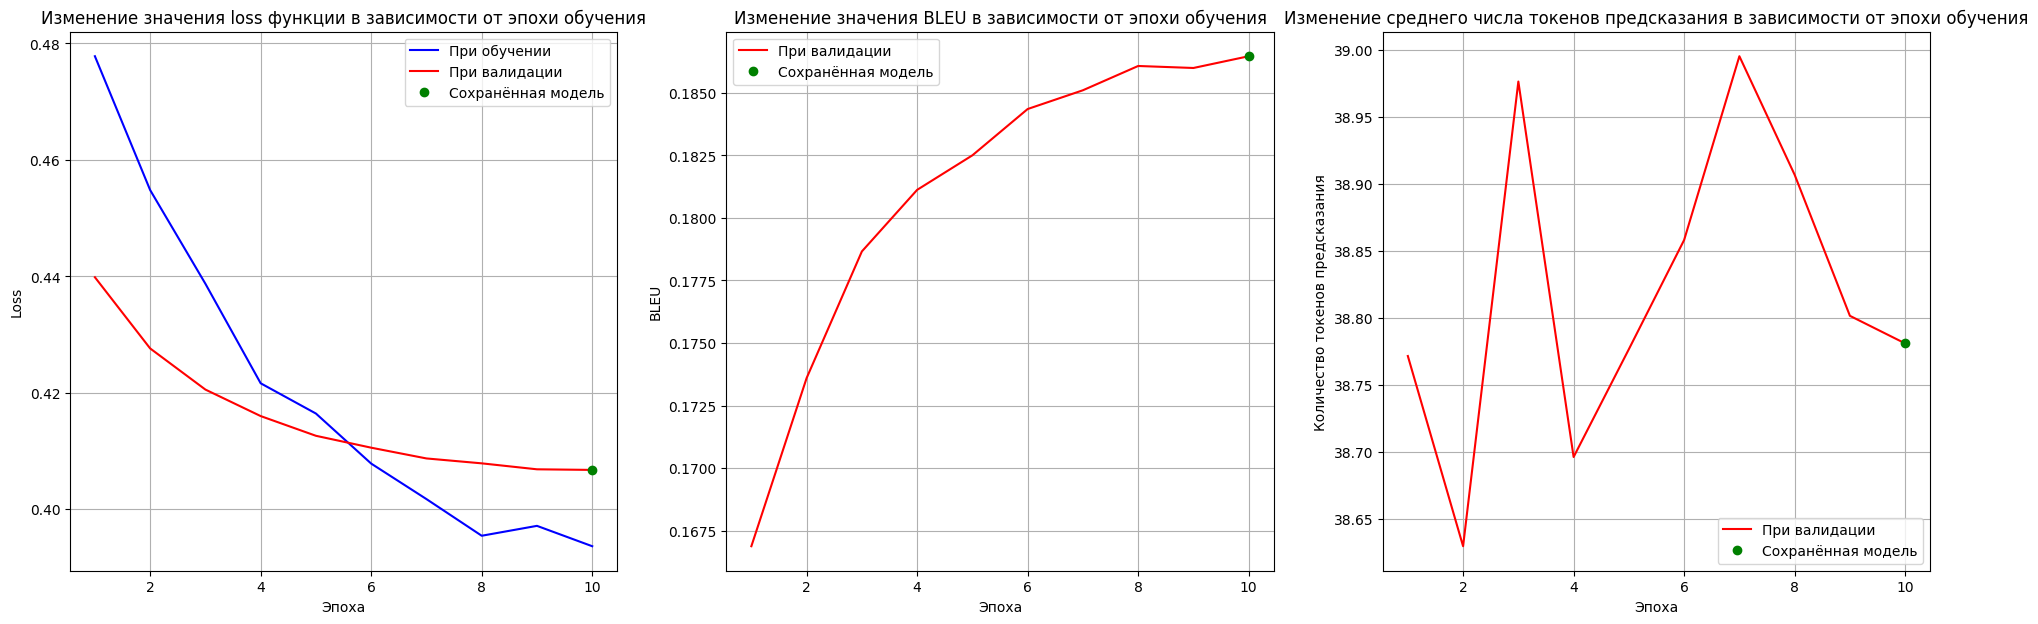

In [28]:
plot_history(history)